In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline


## My approach
We all know that 118 is not enough for deep learning model to get good performance, also small object 
detection is kind of tricky, My idea is that to divide the image into the grid (100x100 for example) an then
train classification or regression how many bees are in the picture. Both approaches are the same when it comes to model
performance so I take classification approach, Divide my images into 100x100 small images and train resnet34
to classify how many bees are in the picture.

This approach, of course, is not ideal and have some disadvantages that we can discuss more deeply later one, but 
let's see what we can do with it.

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate
import cv2
import numpy as np
import torch.nn as nn
import os

In [3]:
def get_float_labels(path):
    image_name = os.path.basename(path)
    
    name = image_name.split('.')[0]
    annotation_path = f"data/grid_mask/{name}.png"
    image = cv2.imread(annotation_path, cv2.IMREAD_UNCHANGED)
    return np.count_nonzero(image)


Prepare data, split 100x100 images into valid(25 %) and train(75 %) set, add some transformations to the image to get more data from it.

In [4]:
data = (ImageList.from_folder("data/grid_image")
 .split_by_rand_pct(seed=2)
 .label_from_func(get_float_labels)
 .transform(get_transforms(), size=100)
 .databunch(bs=512)).normalize(imagenet_stats)


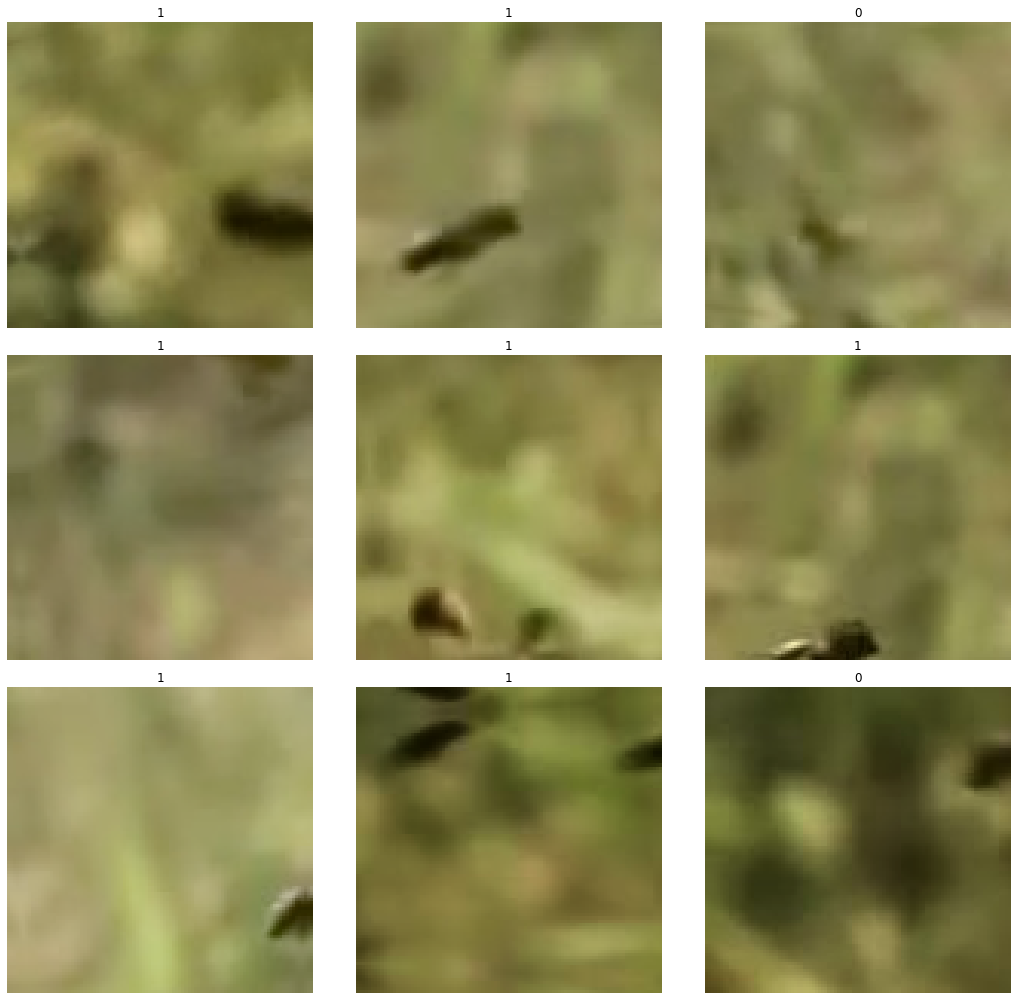

In [5]:
data.show_batch(rows=3, figsize=(15,14))

as we now data is very unbalanced so, we can't measure model just with it's accuracy, I think that better way is to use kappa matrix, also observe precision and recall and finally comfusion matrix itself.

In [6]:
kappa = KappaScore()
kappa.weights = "quadratic"

In [7]:
learn = cnn_learner(data, models.resnet34, metrics=[accuracy, kappa, Precision(average='macro'), Recall(average='macro')])
learn.loss = MSELossFlat

In [8]:
print(learn)

Learner(data=ImageDataBunch;

Train: LabelList (2266 items)
x: ImageList
Image (3, 100, 100),Image (3, 100, 100),Image (3, 100, 100),Image (3, 100, 100),Image (3, 100, 100)
y: CategoryList
2,2,0,0,1
Path: data/grid_image;

Valid: LabelList (566 items)
x: ImageList
Image (3, 100, 100),Image (3, 100, 100),Image (3, 100, 100),Image (3, 100, 100),Image (3, 100, 100)
y: CategoryList
2,0,0,1,1
Path: data/grid_image;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU

In [9]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


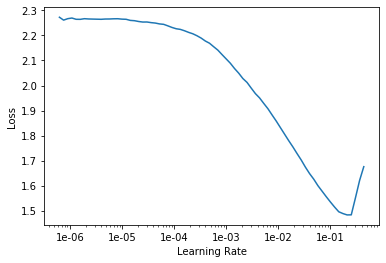

In [10]:
learn.recorder.plot()

In [11]:
learn.fit_one_cycle(10, max_lr=1e-2)

epoch,train_loss,valid_loss,accuracy,kappa_score,precision,recall,time
0,2.059598,1.578408,0.434629,0.071428,0.270816,0.217271,00:04
1,1.757055,1.234055,0.644876,0.623027,0.314739,0.331772,00:03
2,1.549276,1.462327,0.613074,0.670511,0.363403,0.365411,00:03
3,1.360325,1.212073,0.643110,0.661383,0.364709,0.343492,00:03
4,1.210902,0.849037,0.699647,0.765118,0.419167,0.393052,00:03
5,1.091615,0.762676,0.731449,0.764363,0.424686,0.383768,00:03
6,1.004735,0.721109,0.740283,0.795350,0.461256,0.428677,00:03
7,0.935808,0.695172,0.740283,0.802428,0.462736,0.461672,00:03
8,0.875978,0.655264,0.759717,0.825579,0.466468,0.464145,00:03
9,0.832195,0.640652,0.756184,0.825303,0.462179,0.466341,00:03


In [12]:
learn.fit_one_cycle(4, max_lr=1e-2)

epoch,train_loss,valid_loss,accuracy,kappa_score,precision,recall,time
0,0.548710,0.609529,0.756184,0.828565,0.444660,0.432450,00:03
1,0.534550,0.628585,0.763251,0.834951,0.470491,0.481002,00:03
2,0.530903,0.643055,0.756184,0.832973,0.464925,0.451217,00:03
3,0.525256,0.616395,0.766784,0.844308,0.469166,0.459022,00:03


In [13]:
learn.save("100x100_baseline")

now we can unfreeze whole model to train all layers, find learning rate and try to beat existing model.

In [14]:
learn.unfreeze()

In [15]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


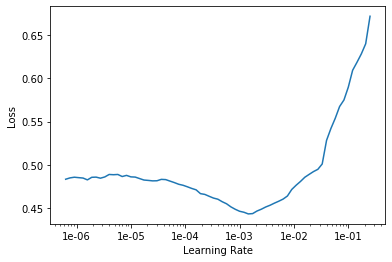

In [16]:
learn.recorder.plot()

In [17]:
learn.fit_one_cycle(20, max_lr=slice(1e-6,1e-3))

epoch,train_loss,valid_loss,accuracy,kappa_score,precision,recall,time
0,0.483869,0.594393,0.772085,0.841823,0.466758,0.460529,00:03
1,0.483602,0.583764,0.766784,0.840293,0.463867,0.454195,00:04
2,0.488670,0.575989,0.765018,0.838621,0.463196,0.452645,00:03
3,0.481444,0.570109,0.761484,0.835839,0.469743,0.448647,00:03
4,0.478055,0.561132,0.757951,0.839626,0.466298,0.450115,00:03
5,0.470640,0.565742,0.752650,0.833249,0.448891,0.436968,00:04
6,0.463875,0.571607,0.768551,0.844471,0.479225,0.486477,00:04
7,0.455711,0.572325,0.761484,0.832025,0.452292,0.434031,00:04
8,0.449825,0.580046,0.756184,0.829068,0.434390,0.423242,00:03
9,0.445995,0.575722,0.772085,0.844463,0.482845,0.468841,00:03


In [18]:
learn.save("final_result")

In [19]:
interp = ClassificationInterpretation.from_learner(learn)

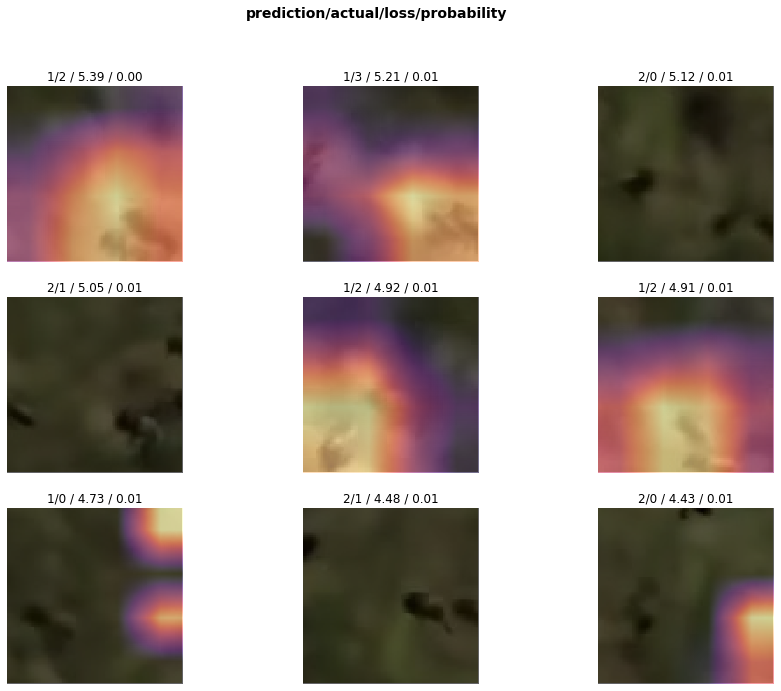

In [20]:
interp.plot_top_losses(9, figsize=(15,11))


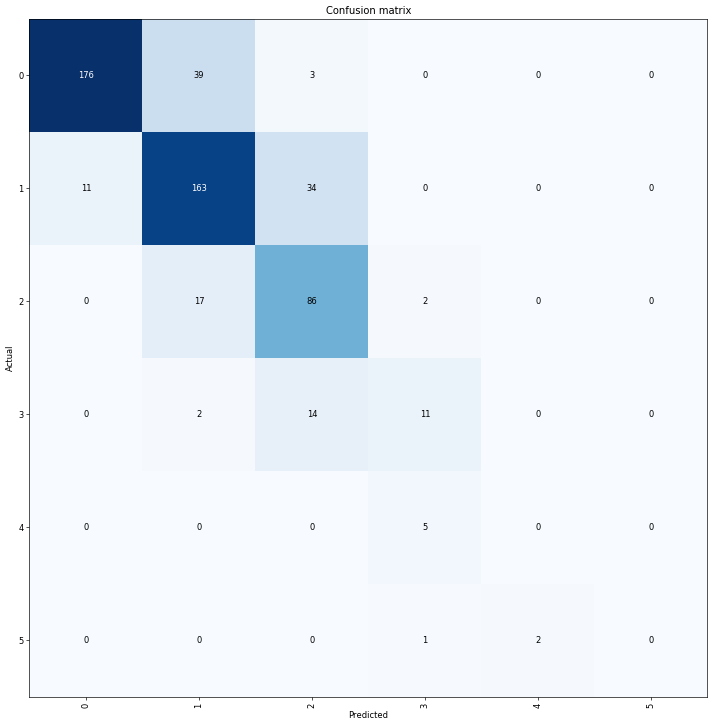

In [21]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)


In [22]:
def save_function(model, save_model_path, batch_size=1):
    model.precompute = False
    model = model.model
    model[0].bs = batch_size
    model.eval()

    torch.save(model, save_model_path)

In [23]:
save_function(learn, "bee_weights_v_0_1.pth")

In [24]:
data.classes

[0, 1, 2, 3, 4, 5]